In [1]:
from maskmm.ipstartup import *
import os
from os.path import join
import torch
from skimage.io import imshow

from maskmm.models.maskrcnn import MaskRCNN
from maskmm import learner
from maskmm.utils import visualize

from maskmm.datasets.nuke.config import Config
from maskmm.datasets.nuke.dataset import Dataset

# debugging
from maskmm.tracker import *
tracker.__init__("maskmm", enabled=True, tolerance=0,
                exclude_vars=("build_rpn_targets.config"))
tracker.clear()
load0 = Tracker("maskmm0").load

ROOT_DIR = "/home/ubuntu/maskmm"
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "data/models/mask_rcnn_coco.pth")
DATA = join(expanduser("~"), "data", "nuke") 

class Config(Config):
    NAME = "mm"
    STEPS_PER_EPOCH = 3
    VALIDATION_STEPS = 1
    GPU_COUNT=1
    COMPAT = True
    AUGMENT = False
config = Config()
rngreset()

[maskmm.ipstartup:INFO]: (ipstartup.py:17, time=14:53)


In [2]:
# Pre-defined layer regular expressions
layer_regex = {
    # all layers but the backbone
    "heads": r"(fpn.P5\_.*)|(fpn.P4\_.*)|(fpn.P3\_.*)|(fpn.P2\_.*)|(rpn.*)|(classifier.*)|(mask.*)",
    # From a specific Resnet stage and up
    "3+": r"(fpn.C3.*)|(fpn.C4.*)|(fpn.C5.*)|(fpn.P5\_.*)|(fpn.P4\_.*)|(fpn.P3\_.*)|(fpn.P2\_.*)|(rpn.*)|(classifier.*)|(mask.*)",
    "4+": r"(fpn.C4.*)|(fpn.C5.*)|(fpn.P5\_.*)|(fpn.P4\_.*)|(fpn.P3\_.*)|(fpn.P2\_.*)|(rpn.*)|(classifier.*)|(mask.*)",
    "5+": r"(fpn.C5.*)|(fpn.P5\_.*)|(fpn.P4\_.*)|(fpn.P3\_.*)|(fpn.P2\_.*)|(rpn.*)|(classifier.*)|(mask.*)",
    # All layers
    "all": ".*",
}
layers = layer_regex["heads"]

[root:INFO]:starting (cellevents.py:36, time=14:53)


time: 1.65 ms


In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

[root:INFO]:starting (cellevents.py:36, time=14:53)


time: 1.41 ms


## Dataset

In [4]:
# create validation sample
pvalid = .2
trainpath = join(DATA, "stage1_train")
df = pd.DataFrame(os.listdir(trainpath), columns=["image"])
df["subset"] = np.random.random(len(df))>pvalid
df.loc[df.subset==True, "subset"] = "train"
df.loc[df.subset==False, "subset"] = "valid"

df.to_pickle(join(DATA, "subset.pkl"))
df.subset.value_counts()

[root:INFO]:starting (cellevents.py:36, time=14:53)


train    505
valid    123
Name: subset, dtype: int64

time: 195 ms


In [5]:
train_ds = Dataset(config)
train_ds.load_nuke(trainpath, "train")
train_ds.prepare()

val_ds = Dataset(config)
val_ds.load_nuke(trainpath, "valid")
val_ds.prepare()

[root:INFO]:starting (cellevents.py:36, time=14:53)


time: 62.2 ms


In [6]:
%%s
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = train_ds.load_image(image_id)
    mask, class_ids = train_ds.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_ds.class_names)

[root:INFO]:starting (cellevents.py:36, time=14:53)


time: 1.16 ms


## Create Model

In [7]:
model = MaskRCNN(model_dir=MODEL_DIR, config=config).to(config.DEVICE)
model.initialize_weights()

# load pretrained except final layers that depend on NUM_CLASSES
params = torch.load(COCO_MODEL_PATH)
params.pop('classifier.linear_class.weight')
params.pop("classifier.linear_bbox.weight")
params.pop("mask.conv5.weight")
params.pop('classifier.linear_class.bias')
params.pop("classifier.linear_bbox.bias")
params.pop("mask.conv5.bias")
model.load_state_dict(params, strict=False)
_ = model.to(config.DEVICE)
model.set_trainable(layers)

[root:INFO]:starting (cellevents.py:36, time=14:53)


time: 666 ms


# maskmm learner

[root:INFO]:starting (cellevents.py:36, time=14:54)



Starting at epoch 1. LR=0.01

Checkpoint Path: /home/ubuntu/maskmm/logs/mm20181031_1453/mask_rcnn_mm_{:04d}.pth
Epoch 1/1.
	1/3 |███-------| 33.3% Complete - loss: 2.00148 - rpn_class_loss: 0.07068 - rpn_bbox_loss: 0.16219 - mrcnn_class_loss: 0.76650 - mrcnn_bbox_loss: 0.54524 - mrcnn_mask_loss: 0.45687
	2/3 |██████----| 66.7% Complete - loss: 5.44176 - rpn_class_loss: 1.67141 - rpn_bbox_loss: 1.56304 - mrcnn_class_loss: 1.23209 - mrcnn_bbox_loss: 0.59029 - mrcnn_mask_loss: 0.38494
	3/3 |██████████| 100.0% Complete - loss: 14.47752 - rpn_class_loss: 13.78557 - rpn_bbox_loss: 0.69194 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000

	1/1 |██████████| 100.0% Complete - loss: 2.52172 - rpn_class_loss: 0.34536 - rpn_bbox_loss: 0.35786 - mrcnn_class_loss: 0.97139 - mrcnn_bbox_loss: 0.57385 - mrcnn_mask_loss: 0.27326



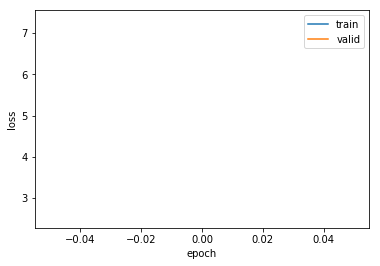

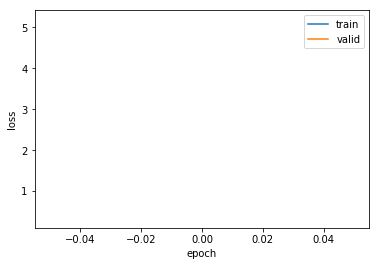

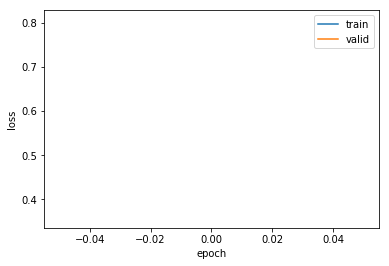

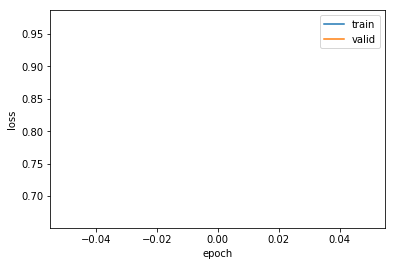

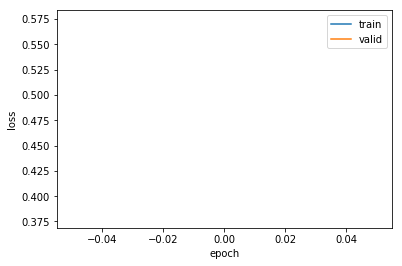

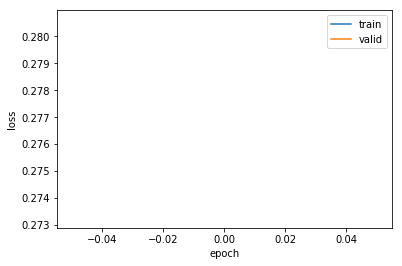

time: 20.2 s


In [9]:
# Create model in training mode
m = learner.Learner(model, train_ds, val_ds)
m.train(.01, 1, "heads")